In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import sys
import torch
import random
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

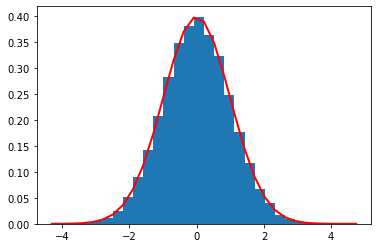

In [2]:
mu1 = 0
sigma1 = 1
A = np.random.normal(mu1, sigma1, 60000)
count, bins, ignored = plt.hist(A, 30, density=True)
plt.plot(bins, 1/(sigma1 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu1)**2 / (2 * sigma1**2) ),
         linewidth=2, color='r')
plt.show()

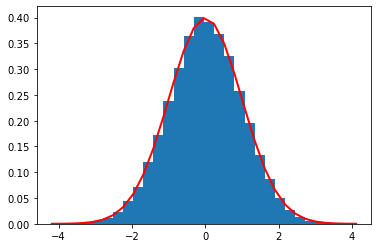

In [3]:
mu2 = 0
sigma2 = 1
B = np.random.normal(mu2, sigma2, 60000)
count, bins, ignored = plt.hist(B, 30, density=True)
plt.plot(bins, 1/(sigma2 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu2)**2 / (2 * sigma2**2) ),
         linewidth=2, color='r')
plt.show()

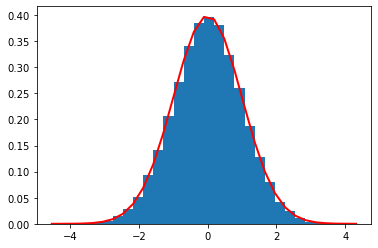

In [4]:
mu3 = 0
sigma3 = 1
C = np.random.normal(mu3, sigma3, 60000)
count, bins, ignored = plt.hist(C, 30, density=True)
plt.plot(bins, 1/(sigma3 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu3)**2 / (2 * sigma3**2) ),
         linewidth=2, color='r')
plt.show()

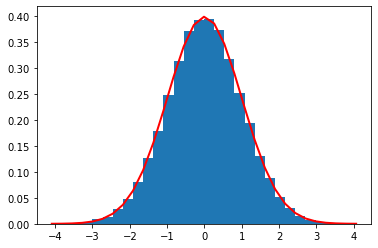

In [5]:
mu3 = 0
sigma3 = 1
D = np.random.normal(mu3, sigma3, 60000)
count, bins, ignored = plt.hist(D, 30, density=True)
plt.plot(bins, 1/(sigma3 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu3)**2 / (2 * sigma3**2) ),
         linewidth=2, color='r')
plt.show()

In [6]:
data = np.vstack((A, B, C, D))
data = data.transpose()
df = pd.DataFrame(data = data, index=list(range(60000)), columns = ['A', 'B', 'C', 'D'])
df['Y'] = 0 #default is health

In [7]:
df.head(5)

,A,B,C,D,Y
0,-1.009275,-0.428978,-0.462204,-0.730648,0
1,-0.832741,0.593039,1.716319,0.897010,0
2,0.817501,-2.081929,1.278260,-0.158938,0
3,1.225925,-0.115383,-0.174284,-0.639618,0
4,-0.001664,1.105585,0.028690,0.863477,0


In [8]:
A_ = 0.5
B_ = 0.4
C_ = 0
D_ = 0.5

# The possible of unhealthy subsets

- case 1: feature A is outside of normal range  25\% of negative data
- case 2: feature B and C are outside of normal ranges 0.3 * 0.5
- case 3: feature B and D are outside of normal ranges 0.3 * 0.33

In [9]:
# df.iloc[(df.A < A_) | ((df.B < B_) & (df.C < C_)) | ((df.B < B_) & (df.D < D_)),4] = 0

In [10]:
df.iloc[(df.A > A_) | ((df.B > B_) & (df.C > C_)) | ((df.B > B_) & (df.D > D_)), 4] = 1

In [11]:
df.head(20)

,A,B,C,D,Y
0,-1.009275,-0.428978,-0.462204,-0.730648,0
1,-0.832741,0.593039,1.716319,0.897010,1
2,0.817501,-2.081929,1.278260,-0.158938,1
3,1.225925,-0.115383,-0.174284,-0.639618,1
4,-0.001664,1.105585,0.028690,0.863477,1
5,-1.500964,-0.213282,0.872136,1.516245,0
6,0.355551,0.618780,1.396819,-0.427265,1
7,-2.515172,0.678266,1.690465,-1.002058,1
8,-1.724586,0.031653,-0.057676,0.341478,0
9,2.267566,-0.235431,-0.524848,0.502396,1


In [12]:
#df.to_csv("synthetic_data_simple.csv", header = False, index = False)

In [13]:
(df.Y == 0).sum()

32041

In [14]:
(df.Y == 1).sum()

27959

In [15]:
dataset = df.to_numpy().astype(np.float32)
train, val, test = dataset[0:30000, ], dataset[30000:45000, ], dataset[45000:60000, ]
train_x, train_y = train[:, 0:4], train[:, 4:5]
val_x, val_y = val[:, 0:4], val[:, 4:5]
test_x, test_y = test[:, 0:4], test[:, 4:5]
DTrain = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
DVal = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
DTest = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(DTrain, batch_size = 32) 
val_loader = DataLoader(DVal, batch_size = 32) 
test_loader = DataLoader(DTest, batch_size = 32)

In [16]:
def epoch_train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc

def epoch_val(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for  batch_idx, (data, target) in enumerate(iterator):
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    return epoch_loss / len(iterator.dataset), acc


In [18]:
model = nn.Sequential(
        nn.Linear(4, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        nn.Sigmoid(),
        )

#optimizer = optim.SGD(model.parameters(), lr = 0.02)
optimizer = optim.Adam(model.parameters(), lr = 0.02)
criterion = nn.BCELoss()
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)

best_model = None
best_acc = -float('inf')


for epoch in range(50):
    train_loss, train_acc = epoch_train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = epoch_val(model, val_loader, criterion, device)

    if valid_acc > best_acc:
        best_model = copy.deepcopy(model)
        best_acc = valid_acc

    if epoch % 5 == 0:
        print(f"Epoch : {epoch} | Train Loss: {train_loss:.3f} | Train acc: {train_acc:.3f}")
        print(f"Epoch : {epoch} | Val. Loss: {valid_loss:.3f} | Val acc: {valid_acc:.3f}")

test_loss, test_acc = epoch_val(best_model, test_loader, criterion, device)
print(f"Test. Loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")
torch.save(best_model, "synthetic_model_simple.pt")


Epoch : 0 | Train Loss: 0.113 | Train acc: 0.952
Epoch : 0 | Val. Loss: 0.239 | Val acc: 0.958
Epoch : 5 | Train Loss: 0.036 | Train acc: 0.986
Epoch : 5 | Val. Loss: 0.044 | Val acc: 0.983
Epoch : 10 | Train Loss: 0.028 | Train acc: 0.990
Epoch : 10 | Val. Loss: 0.028 | Val acc: 0.988
Epoch : 15 | Train Loss: 0.024 | Train acc: 0.991
Epoch : 15 | Val. Loss: 0.043 | Val acc: 0.986
Epoch : 20 | Train Loss: 0.021 | Train acc: 0.992
Epoch : 20 | Val. Loss: 0.022 | Val acc: 0.991
Epoch : 25 | Train Loss: 0.020 | Train acc: 0.992
Epoch : 25 | Val. Loss: 0.021 | Val acc: 0.991
Epoch : 30 | Train Loss: 0.019 | Train acc: 0.993
Epoch : 30 | Val. Loss: 0.021 | Val acc: 0.992
Epoch : 35 | Train Loss: 0.019 | Train acc: 0.993
Epoch : 35 | Val. Loss: 0.017 | Val acc: 0.993
Epoch : 40 | Train Loss: 0.017 | Train acc: 0.993
Epoch : 40 | Val. Loss: 0.020 | Val acc: 0.992
Epoch : 45 | Train Loss: 0.016 | Train acc: 0.994
Epoch : 45 | Val. Loss: 0.014 | Val acc: 0.994
Test. Loss: 0.016 | Test acc: 0.99

In [19]:
probs = best_model(torch.from_numpy(dataset[:, 0:4]))

In [20]:
probs = probs.detach().numpy()

In [21]:
probs = probs.squeeze()

In [22]:
idx = np.where((probs > 0.1) & (probs < 0.9))[0]

In [23]:
print(idx)

[   75    99   245   297   300   312   331   335   339   349   352   397
   440   553   594   629   730   817   841   897  1040  1073  1074  1275
  1329  1335  1575  1625  1707  1881  1940  1949  1955  2240  2268  2275
  2305  2428  2445  2706  2801  2859  3004  3024  3112  3123  3142  3188
  3308  3384  3396  3524  3563  3596  3621  3666  3700  3709  3859  3978
  4048  4061  4112  4239  4266  4460  4525  4691  4736  4793  5025  5281
  5317  5330  5360  5378  5489  5543  5555  5597  5786  5958  5986  5998
  6065  6115  6127  6286  6293  6454  6482  6484  6702  6736  6757  6796
  6813  6943  7012  7174  7323  7336  7467  7515  7530  7579  7696  7830
  8007  8037  8175  8220  8261  8479  8507  8616  8652  8676  8869  9132
  9219  9328  9333  9363  9427  9442  9469  9711  9716  9755  9797  9880
  9917  9961  9974 10021 10089 10166 10173 10254 10324 10380 10425 10522
 10844 10877 10968 11043 11068 11211 11333 11348 11364 11561 11594 11605
 11652 11684 11712 11778 11882 11913 11949 12014 12

In [24]:
df1 = df.drop(idx)

In [25]:
print(df1.shape)

(59237, 5)


In [27]:
df1[0:20000].to_csv("synthetic_data_simple.csv", header = False, index = False)

In [26]:
df1.iloc[0:20000]

,A,B,C,D,Y
0,-1.009275,-0.428978,-0.462204,-0.730648,0
1,-0.832741,0.593039,1.716319,0.897010,1
2,0.817501,-2.081929,1.278260,-0.158938,1
3,1.225925,-0.115383,-0.174284,-0.639618,1
4,-0.001664,1.105585,0.028690,0.863477,1
...,...,...,...,...,...
20255,0.470821,-0.394467,-0.707651,0.284233,0
20256,1.209141,-0.244231,0.168766,0.031976,1
20257,-1.946072,-0.147127,-0.623025,1.497357,0
20258,-0.750737,0.840652,-0.268642,-0.069665,0
